In [ ]:
# we need the following libraries, so let's install them
%pip install matplotlib
%pip install scikit-learn
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [9]:
whole_data = whole_data[~pd.isnull(whole_data['New_sex'])]
whole_data.head()

,Unnamed: 0,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,New_sex
0,0,-405.629779,49.662019,2.341686e+09,4.640159,330.131351,1.720449,196.329468,157.375266,-175.517427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,-184.213315,696.721558,9.120388e+09,5.511916,546.484323,1.844329,865.631409,276.160265,250.186759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2,-676.460406,214.247101,1.203117e+10,5.623317,525.821607,2.576996,818.862732,290.994217,-295.582659,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,3,-741.963159,322.000031,9.176606e+09,5.658210,558.405931,2.510349,694.258850,322.914612,-331.656328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,4,-608.359229,232.310629,3.715405e+09,5.523623,506.580425,2.096828,489.584351,266.226002,-238.386621,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0


In [10]:
random_seed = 21202
del whole_data['Unnamed: 0']
whole_data.head()
whole_data = whole_data.sample(frac=1.0, random_state=random_seed)

In [11]:
# finding total number of samples:
n_samples = whole_data.shape[0]
print("number of samples are: {}".format(n_samples))

number of samples are: 111086


In [12]:
# names of all targets:
targets_names = list(whole_data.iloc[:,464:])
print(targets_names)

['index', 'Image Index', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'New_sex']


In [13]:
# finding the number of unique subjects:
unique_subjects = pd.unique(whole_data['Patient ID'])
print('The number of unique subjects are: {0}'.format(len(unique_subjects)))

The number of unique subjects are: 30703


In [14]:
# preallocating the frequency of session of the subjects:
# this is written to make sure that we dont use a subject in both training and testing split.
test_split = 0.06       # precent out of total samples
valid_split = 0.1       # precent out of total samples (this is the sumation of both training and validation splits)

n_test = n_samples * test_split
n_whole_train = n_samples - n_test

frequencies = np.ones((unique_subjects.shape[0], 4)) * np.nan
for i, sbj in tqdm(enumerate(unique_subjects)):
  frequencies[i, 0] = sbj
  frequencies[i, 1] = (whole_data['Patient ID'] == sbj).sum()
cumolative_sums_of_samples = np.cumsum(frequencies[:,1])
frequencies[:, 2] = cumolative_sums_of_samples
frequencies[:, 3] = cumolative_sums_of_samples/cumolative_sums_of_samples[~0]

30703it [00:10, 3034.09it/s]


In [15]:
# visualizing the frequency  of subjects and images taken from each
vis_frequencies = pd.DataFrame(frequencies,columns=['subject_ID','n_of_sessions/images','cumolative_sessions','preccent_of_number_of_images'])
vis_frequencies.head(15)

,subject_ID,n_of_sessions/images,cumolative_sessions,preccent_of_number_of_images
0,27115.0,4.0,4.0,0.000036
1,2046.0,6.0,10.0,0.000090
2,6991.0,15.0,25.0,0.000225
3,19339.0,2.0,27.0,0.000243
4,13670.0,163.0,190.0,0.001710
5,5365.0,30.0,220.0,0.001980
6,6179.0,1.0,221.0,0.001989
7,22618.0,4.0,225.0,0.002025
8,16043.0,6.0,231.0,0.002079
9,19550.0,19.0,250.0,0.002251


In [16]:
# separating the testing split without having any mutual_subjects:
testing_subjects_masking = vis_frequencies['preccent_of_number_of_images'] < test_split
testing_subjects = vis_frequencies[testing_subjects_masking]['subject_ID'].values.tolist()
whole_train_subjects = vis_frequencies[~testing_subjects_masking]['subject_ID'].values.tolist()

In [17]:
# excluding irrelevant features
excluding2ds =  np.concatenate( (np.arange(32,41,dtype=int),
                                 np.arange(32,41,dtype=int)+ 116,
                                 np.arange(32,41,dtype=int)+116*2,
                                 np.arange(32,41,dtype=int)+116*3))

whole_data.drop(whole_data.columns[excluding2ds.tolist()],axis = 1,inplace=True)

In [18]:
# separating test_data and whole_trainig_data
Test = whole_data[whole_data['Patient ID'].isin(testing_subjects)]
X_test, y_test = Test.iloc[:,:464-36].values, Test['New_sex'].values

# separating test_data and whole_trainig_data
Train = whole_data[whole_data['Patient ID'].isin(whole_train_subjects)]

# the size of training/testing_split:
print('The size of the testing split is: {}'.format(Test.shape))
print('The size of the whole trainig (train + valid) split is: {}'.format(Train.shape))

The size of the testing split is: (6664, 450)
The size of the whole trainig (train + valid) split is: (104422, 450)


In [19]:
# splitting the validation split:
X_train, X_val, y_train, y_val = train_test_split(Train.iloc[:,:464-36].values,
                                                  Train['New_sex'].values,
                                                  test_size=valid_split,
                                                  random_state=random_seed
                                                  )

In [20]:
inc = 100
# Create a PCA object
pca = PCA(n_components=5)

# Fit the PCA object to the data
pca.fit_transform(X_train[::inc,:])

# Get the principal components
PCs = pca.components_

# Get the variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

# Print the principal components and their variance explained
for i, PC in enumerate(PCs):
    # print('PC {}: {}'.format(i+1, PC))
    print('   Explained variance: {}'.format(explained_variance[i]))

conv = X_train[::inc,:]@pca.components_.T

   Explained variance: 0.5900411438531388
   Explained variance: 0.3216115163021699
   Explained variance: 0.050249540473341986
   Explained variance: 0.038085209081961106
   Explained variance: 1.0423441184543288e-05


In [21]:
# Create a LDA model
model = LinearDiscriminantAnalysis()

# Fit the model to the data
# model.fit(X_train[::inc,:], y_train[::inc])

# Predict the labels of new data
predictions = model.fit_transform(X_train[::inc,:], y_train[::inc])

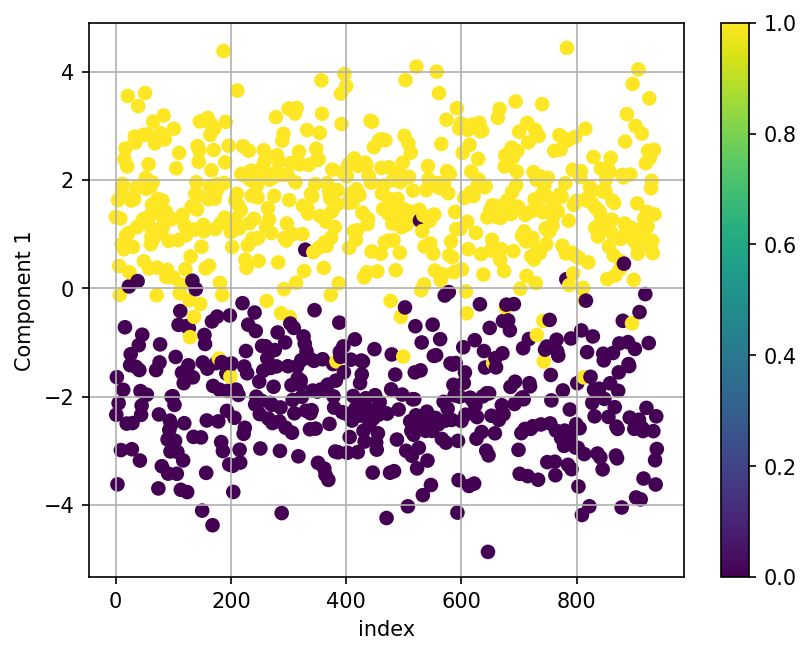

In [22]:
# Load the data
# Create a t-SNE model
tsne = TSNE(n_components=2, perplexity=15,verbose=True,n_iter=2000)
# Fit the model to the data
# tsne_X = tsne.fit_transform(conv)
# Plot the data
plt.figure(dpi=150)
plt.scatter(np.arange(len(predictions)),predictions, c=y_train[::inc])
plt.colorbar()
plt.grid(which='both')
plt.xlabel('index')
plt.ylabel('Component 1')
plt.show()
np.save('/content/gdrive/MyDrive/radiomics/TSNE_nih_sex.npy',{'comp':predictions,'c':y_train[::inc]})